Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train_master = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test_master = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
from sklearn.model_selection import train_test_split
train_percent = 0.75
def reset_train(train_percent):
  train,val = train_test_split(train_master,train_size=train_percent,stratify = train_master['status_group'],random_state=26)
  return train,val
train,val = reset_train(train_percent)
test=test_master
train.shape,val.shape, test.shape



((44550, 41), (14850, 41), (14358, 40))

In [4]:
import numpy as np

In [5]:
def wrangle(X):
  #Prevent set with copy warning
  X= X.copy()

  #Latitude has small values around 3 (noise in data should be 0)
  #replace small values with 0
  X['latitude'] = X['latitude'].replace(-2e-08,0)

  #When there are zeroes for long and lat they should be np.nan
  cols_with_zeroes = ['longitude','latitude']
  for col in cols_with_zeroes:
    X[col] = X[col].replace(0,np.nan)

  #quantity and quantity_group are duplicates (drop one)
  X = X.drop(columns='quantity_group')

  #return wrangled data frame
  return X 
  
train = wrangle(train_master)
val = wrangle(val)
test = wrangle(test_master)

##Select Features:

In [6]:
#Set Target
target = 'status_group'

#Set Features:

#A Dataframe with just the features
train_features = train.drop(columns=[target,'id'])

#List of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# I don't want cat variables with high cardinality:
cardinality = train_features.select_dtypes(exclude='number').nunique()

#get a list of the categorical features:
categorical_features = cardinality[cardinality<=50].index.tolist()

#combine lists for features used in model

features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [7]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

## Using Pipelines


In [11]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators =50,
                           n_jobs = -2,
                           max_features= 30,
                           random_state = 26,
                           min_samples_leaf=10,
                           criterion='entropy')
)

#fitting the above model
pipeline.fit(X_train,y_train)

#accuracy scores
print('Train Accuracy',pipeline.score(X_train,y_train))
print('Validation Accuracy',pipeline.score(X_val,y_val))

Train Accuracy 0.8567508417508417
Validation Accuracy 0.8565656565656565


In [12]:
y_pred = pipeline.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [13]:
#I created this submission as a test of my basic forest from tuesday
# submission = test['id']
# y_pred_series = pd.Series(y_pred)
# submission = pd.concat([submission,y_pred_series],axis=1)
# submission.columns=['id','status_group']
# submission.to_csv('Assignment_222-KV.csv',index=False)

I want to check the accuracies of all the individual trees within this forest. and to some degree I want to know their properties to make sure that my conception of the forest, and its parameters are similar to reality.`

In [14]:
rf =pipeline.named_steps['randomforestclassifier']

In [15]:
#I'm fitting the individual trees sequentially to see their accuracies
# plot features : 
import matplotlib.pyplot as plt

train_acc_list = []
val_acc_list = []

for index,i in enumerate(rf.estimators_):
    model2 = i

    pipeline2 = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        model2
    )

    #you can just use one tree from the forest to predict:
    pipeline2.fit(X_train,y_train)
    train_acc = pipeline2.score(X_train,y_train)
    val_acc = pipeline2.score(X_val,y_val)
    
    #Append to list:
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    #accuracy scores
#     print(f'Model {index}')
#     print('Train Accuracy',train_acc)
#     print('Validation Accuracy',val_acc)

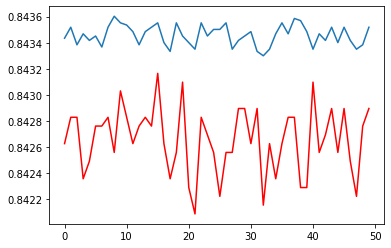

In [16]:
index = range(len(train_acc_list))


plt.plot(index,train_acc_list);
plt.plot(index,val_acc_list,color='red');


Initially I had a strange problem where the model was telling me that the scores started out all the same, and then steadily increased to a final value of around 83 percent accurate

Some troubleshooting notes from that:

I'm not sure why this is. Maybe I set some sort of parameter incorrectly, but this also means that the last models are going to be the most accurate both on test and train.. lets try using just those models?

I reran the cell and the graph changed... now all values are around .83? This is still weird, because the random forest regressor should be making unique trees, this seems closer to a parameter issue.

ACTUALLY the problem was that within the loop I had used `pipeline` to guess instead of `pipeline2`. So even thought I was producing a bunch of models, I wasn't getting a training/val score for any of the models. I was repeatedly getting a training/val score for my original pipeline instead of the new one definied within the loop

In [22]:
rf.estimators_[40]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=30, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=660155250, splitter='best')

In [20]:
model2 = rf.estimators_[40]
pipeline2 = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        model2
    )


pipeline2.fit(X_train,y_train)
train_acc = pipeline2.score(X_train,y_train)
val_acc = pipeline2.score(X_val,y_val)
print('Train Accuracy',train_acc)
print('Validation Accuracy',val_acc)

Train Accuracy 0.8433501683501684
Validation Accuracy 0.8430976430976431


In [21]:
y_pred = pipeline2.predict(X_val)

NameError: name 'pipeline2' is not defined

In [23]:
#Now lets create a confusion matrix for this:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# confusion_matrix(y_val,y_pred)

In [24]:
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [26]:
import seaborn as sns
def plot_confusion_matrix(y_true,y_pred):
    labels=unique_labels(y_true)
    columns = [f'predicted {label}' for label in labels]
    index = [f'actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true,y_pred),
                        columns=columns,index=index)
    return sns.heatmap(table,annot=True,fmt='d',cmap='viridis')
# plot_confusion_matrix(y_val,y_pred)

In [32]:
from sklearn.metrics import classification_report
# print(classification_report(y_val,y_pred))

In [29]:
def view_metrics(y_true,y_pred):
    print(classification_report(y_true,y_pred))
    plot_confusion_matrix(y_true,y_pred)
    
# view_metrics(y_val,y_pred)
    

In [29]:
# I created this submission to test one of the trees from the forest.
y_pred = pipeline2.predict(X_test)
submission = test['id']
y_pred_series = pd.Series(y_pred)
submission = pd.concat([submission,y_pred_series],axis=1)
submission.columns=['id','status_group']
submission.to_csv('Single_Decision_Tree.csv',index=False)

In [32]:

#Have to redefine importances to get this working:
# n=20
# plt.figure(figsize=(10,n/2))
# plt.title(f'Top {n} features with ordinal encoding')
# importances.sort_values()[-n:].plot.barh(color='grey')

In [33]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


## Hyperparameter Tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators= 50,
                           n_jobs = -2,
                           random_state = 26,                           
                           criterion='entropy')
)
param_distributions= {
    'randomforestclassifier__max_features': list(range(10,30)),
    'randomforestclassifier__min_samples_leaf': list(range(10,30))
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-2
)


#fitting the above model
search.fit(X_train,y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  8

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

                         precision    recall  f1-score   support

             functional       0.84      0.95      0.89      8065
functional needs repair       0.78      0.32      0.46      1079
         non functional       0.90      0.83      0.87      5706

               accuracy                           0.86     14850
              macro avg       0.84      0.70      0.74     14850
           weighted avg       0.86      0.86      0.85     14850



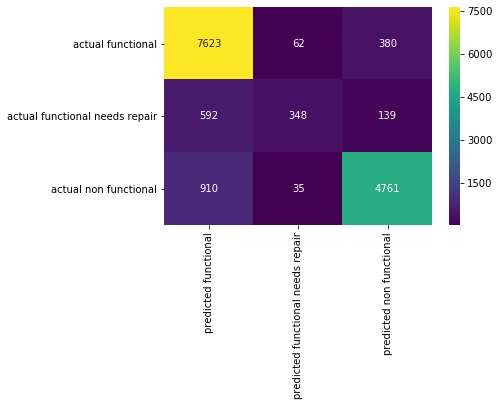

In [39]:
my_pipeline = search.best_estimator_
my_pipeline.score(X_train,y_train)
y_pred = my_pipeline.predict(X_val)
view_metrics(y_val,y_pred)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,1996,35.290799,-4.059696,0,21,3,321,2012,Internal,...,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,0.0,1569,36.656709,-3.309214,0,2,2,300,2000,Pangani,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,0.0,1567,34.767863,-5.004344,0,13,2,500,2010,Internal,...,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,0.0,267,38.058046,-9.418672,0,80,43,250,1987,Ruvuma / Southern Coast,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
4,500.0,1260,35.006123,-10.950412,0,10,3,60,2000,Ruvuma / Southern Coast,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [38]:
#Tree param Tuning:
y_test_pred= my_pipeline.predict(X_test)
submission = test['id']
y_pred_series = pd.Series(y_test_pred)
submission = pd.concat([submission,y_pred_series],axis=1)
submission.columns=['id','status_group']
submission.to_csv('Tuned_forest.csv',index=False)